# Clean and explore a Covid-19 dataset
________________________________________________________________

As the field of data science grows collaborative and Cloud-based, we need to build better tools so that different parties can work together and gain meaningful insights from data. Data owners with sensitive information, such as hospitals who deal with patient confidentiality, have often been left unable to explore and analyse their data because of privacy concerns. BastionLab offers a solution to this problem, while offering security guarantees.

In this tutorial, we are going to walk you through some examples of the ways in which you can clean datasets, run queries and visualize data, without needing access to the data in clear. We will be taking a real-world Covid-19 dataset as our example and handling it remotely via BastionLab's main object, the `RemoteLazyFrame`.

## Pre-requisites
_________________________________________________________________

### Technical requirements

To start this tutorial, ensure the following are already installed in your system:
- Python3.7 or greater (get the latest version of Python at https://www.python.org/downloads/ or with your operating system’s package manager)
- [Python Pip](https://pypi.org/project/pip/) (PyPi), the package manager

### Pip packages and dataset

In order to run this notebook, you will also need to install [Polars](https://www.pola.rs/) and Bastionlab which you can do by running the code block below:

In [ ]:
! pip install polars
! pip install bastionlab

You will also need to download the WHO dataset, which compiles worldwide statitics related to cases of Covid-19 around the globe:

In [3]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1bhanFEGQrZgtQiZgjgi-Op9bsidsh0a6

> *Alternatively, you can download the dataset from Kaggle by following this link: https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset and creating a free user account.* 
>
> *If you download the file via Kaggle, you will need to move the `covid_19_data.csv` file into the same folder as the notebook. Note that some slight differences may exist between the Kaggle dataset and the Google Drive one, so the output of queries may vary when you test them.* 


### Upload the dataset to the server


We'll now install and launch the server. For testing purposes, BastionLab server has been packaged as a pip wheel. In this tutorial, we will use this package to quickly set up a test server:

In [4]:
!pip install bastionlab_server

The server exposes port `50056` for gRPC communication with clients and uses a default configuration (*no authentication, default settings*). These settings are secure enough for the purposes of this tutorial so we won't change them.

To run the server, we use the utility function provided by the `bastionlab_server` package.

In [5]:
import bastionlab_server

srv = bastionlab_server.start()

### Connecting to the remote dataset

Now that's all done, we can finally connect to our server, send over our CSV file and start analysing our data!

First, we read in the dataset using Polar's `read_csv()` function, which returns a Polar's DataFrame instance containing the dataset.

Then, we connect to the server using Bastionlab's `Connection()` method.

In [ ]:
from bastionlab import Connection
import polars as pl

df = pl.read_csv("covid_19_data.csv")

connection = Connection("localhost")

Finally, we send the Polar's DataFrame instance to the server using Bastionlab's `polars.send_df()` method which will return a `RemoteLazyFrame` instance, a reference to the DataFrame uploaded. We will be working with it throughout this tutorial.

In [7]:
rdf = connection.client.polars.send_df(df)

We can now see the list of column names in the dataset by using RemoteDataFrame's `columns()` method.

In [8]:
rdf.columns

['SNo',
 'ObservationDate',
 'Province/State',
 'Country/Region',
 'Last Update',
 'Confirmed',
 'Deaths',
 'Recovered']

## Data cleaning
______________________________________

### Null values

We'll start with figuring out where we might have problems because of missing values in our dataset. 

To do so, we'll calculate what percentage of values are missing from each column:
- We'll take the sum of `is_null()` values in each column.
- We'll multiply them by 100 and divide them by the total rows of that same column.

In order to make this tutorial easier to follow, we'll print out the results of our query using the `.collect()` and .`fetch()` methods necessary to transform the RemoteLazyFrame instance into a readable dataset. 

> *Note - This would ordinarily require the request to be confirmed by the dataset owner, but we previously disabled the data access approval feature on purpose to avoid this here.*

In [9]:
percent_missing = rdf.select(
    pl.col(x).is_null().sum() * 100 / pl.col(x).count() for x in rdf.columns
)
percent_missing.collect().fetch()

SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,26.288361,0.0,0.0,0.0,0.0,0.0


We can see that there are quite a lot of null values in the 'Province/State' column. Let's change these null values to `"Uknown"` by selecting the column `'Province/State'` and using the `fill_null()` method to fill null values with a value of our choice - `"Unknown"` in this case.

To check this has worked, we can output the total sum of null values in the 'Province/State' column, which we can see is now `0`.

In [10]:
rdf = rdf.with_column(pl.col("Province/State")).fill_null("Unknown")
total_nulls = rdf.select(pl.col("Province/State").is_null().sum())
total_nulls.collect().fetch()

Province/State
u32
0


### Column dtypes

Next, we want to check if the column dtypes are the best fit for our dataset. We can list them by printing out the `schema` attribute on our RemoteLazyFrame, which outputs all column names and dtypes. 

In [11]:
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Utf8,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Last Update': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Float64,
 'Deaths': polars.datatypes.Float64,
 'Recovered': polars.datatypes.Float64}

We can see in the previous cell that the dtype of the `'Confirmed'`, `'Deaths'` and `'Recovered'` columns is `f64`. We should only have integer values in these columns so we can change this to `Int64` using the `.cast(pl.Int64)` method. We can right away replace the old columns with the new one by combining it with the `with_columns()` method.

We will also convert the `'ObservationDate'` column to a `pl.Date` type so that we can more easily run queries against the months, days and years within the date. To do this, we need to specify the `format` the dates are written in. 
> *Note - This will not work if you have dates in mixed formats, in which case, you'd need to clean up the data before calling this function.*

Finally, we will drop the `'Last Update'` column as we won't be needing it for the purposes of this tutorial. This column also contains a mix of date formats which can take time to clean and goes beyong the scope of what we cover here. 

> Feel free to get in touch and let us know if you'd like to see a tutorial on this topic, or any other, via our [Discord community](https://discord.com/invite/TxEHagpWd4)!

In [12]:
rdf = rdf.with_columns(
    pl.col(x).cast(pl.Int64, strict=True) for x in ["Confirmed", "Deaths", "Recovered"]
)
rdf = rdf.with_column(
    pl.col("ObservationDate").str.strptime(pl.Date, fmt="%m/%d/%Y", strict=False)
)
rdf = rdf.drop("Last Update")
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Date,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Int64,
 'Deaths': polars.datatypes.Int64,
 'Recovered': polars.datatypes.Int64}

As you can see our changes have been taken into account as expected.

#### Replacing alternative labels with one unique label

By quickly looking over the `.csv` file, we can also see that we have both `"China"` and `"Mainland China"` values in the Country/Region column. We want to group all these values under one label, `"China"`. We can do this using the `.when.then.otherwise()` methods.

To check this has worked, we can print out the sum of unique values in the Country/region column before and after this change. We can see it reduces by one after we replace `"Mainland China"` values with `"China"`.

In [13]:
test = (
    rdf.select(pl.col("Country/Region"))
    .unique()
    .select(pl.col("Country/Region").count())
)
print(test.collect().fetch())

rdf = rdf.with_column(
    pl.when(pl.col("Country/Region") == "Mainland China")
    .then("China")
    .otherwise(pl.col("Country/Region"))
    .alias("Country/Region")
)

test = (
    rdf.select(pl.col("Country/Region"))
    .unique()
    .select(pl.col("Country/Region").count())
)
print(test.collect().fetch())

shape: (1, 1)
┌────────────────┐
│ Country/Region │
│ ---            │
│ u32            │
╞════════════════╡
│ 227            │
└────────────────┘
shape: (1, 1)
┌────────────────┐
│ Country/Region │
│ ---            │
│ u32            │
╞════════════════╡
│ 227            │
└────────────────┘


#### Adding new columns

We also want to add a new column `"Active_cases"`, which will be calculated as following: `Confirmed` - `Deaths` - `Recovered`. 

We can do this by combining the `with_column()` method with the `.when.then.otherwise()` methods.


In [14]:
rdf = rdf.with_column(
    (pl.col("Confirmed") - pl.col("Deaths") - pl.col("Recovered")).alias("Active_cases")
)
rdf.schema

{'SNo': polars.datatypes.Int64,
 'ObservationDate': polars.datatypes.Date,
 'Province/State': polars.datatypes.Utf8,
 'Country/Region': polars.datatypes.Utf8,
 'Confirmed': polars.datatypes.Int64,
 'Deaths': polars.datatypes.Int64,
 'Recovered': polars.datatypes.Int64,
 'Active_cases': polars.datatypes.Int64}

## Data Analysis
_______________________________________________

Now that the dataset has been cleaned and prepared, let's start to analyse the data. 

First, let's run a query to get the total of confirmed cases, deaths, number of people recovered and active cases for G7 countries. For the sake of simplicity, we will only look at the latest data provided by countries on the most recent observation date. A small number of countries did not submit observations on this day and will therefore not be included in these results, but the data is quite sufficent for the sake of this tutorial.

We can display the results by combining the `.collect()` and `.fetch()` to get a printable version of our dataframe.

With default or stricter privacy policies, when you want to `.collect().fetch()` a RemoteLazyFrame, the query will be screened to check that data is sufficiently anonymous. If this is not the case, data access approval from the data owner will be needed.

In [15]:
from datetime import date

cols = ["Deaths", "Confirmed", "Recovered", "Active_cases"]

total = rdf.filter(
    pl.col("ObservationDate") == pl.col("ObservationDate").max()
).select(  # limit to data shared on this observation date
    [pl.col(x).sum() for x in cols]
)  # get the sum of values shared on this date for each category in cols
total.collect().fetch()

Deaths,Confirmed,Recovered,Active_cases
i64,i64,i64,i64
2525401,113784735,64243285,47016049


Let's now take a look at the total confirmed Covid cases for G7 countries. To do this, we first create a filtered down RemoteLazyFrame instance with just the data for G7 countries. Then, we can run a similar query to the previous one, but, this time, we will group the data by country before summing the values for each catgeory on the selected date.

We then limit this dataframe to the highest ten results and `collect().fetch()` the results.

In [16]:
all_cols = ["Confirmed", "Country/Region"]

G7 = rdf.filter(
    (pl.col("Country/Region") == "Canada")
    | (pl.col("Country/Region") == "France")
    | (pl.col("Country/Region") == "Germany")
    | (pl.col("Country/Region") == "Italy")
    | (pl.col("Country/Region") == "UK")
    | (pl.col("Country/Region") == "US")
    | (pl.col("Country/Region") == "Japan")
)

G7_cases = (
    G7.filter(pl.col("ObservationDate") == pl.col("ObservationDate").max())
    .select([pl.col(x) for x in all_cols])
    .groupby(pl.col("Country/Region"))
    .agg(pl.col("Confirmed").sum())
    .sort(pl.col("Confirmed"), reverse=True)
)
G7_cases.collect().fetch()

Country/Region,Confirmed
str,i64
"""US""",28554465
"""UK""",4182772
"""France""",3747263
"""Italy""",2907825
"""Germany""",2444177
"""Canada""",869347
"""Japan""",431093


## Data Visualization
_______________________________________________

### Barplot

We can now easily visualize our `G7_cases` RemoteLazyFrame using the `barplot` function.

We then simply supply the `x` and `y` columns as arguments to the `barplot()` function to get our bar chart visualization. Then we use matplotlib pyplot's `xticks` function to rotate the `x` axes labels by `60` degrees to avoid them overlapping.

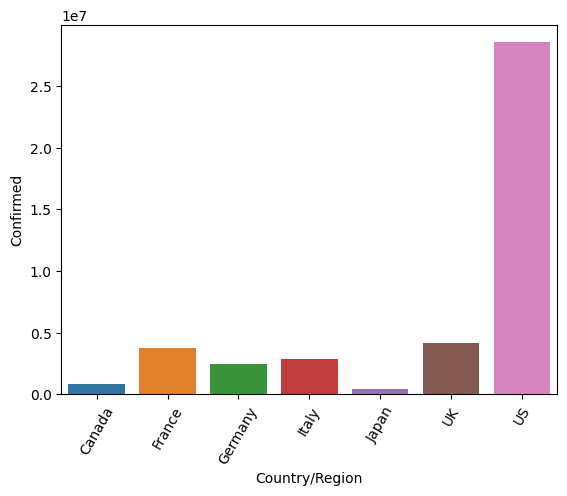

In [17]:
G7_cases.barplot(y="Confirmed", x="Country/Region")

import matplotlib.pyplot as plt

plt.xticks(rotation=60)
plt.show()

We'll also have a look at the evolution of confirmed covid cases in a specific country over a specific time frame. Let's take the UK cases in 2020 from April onwards as our example this time.

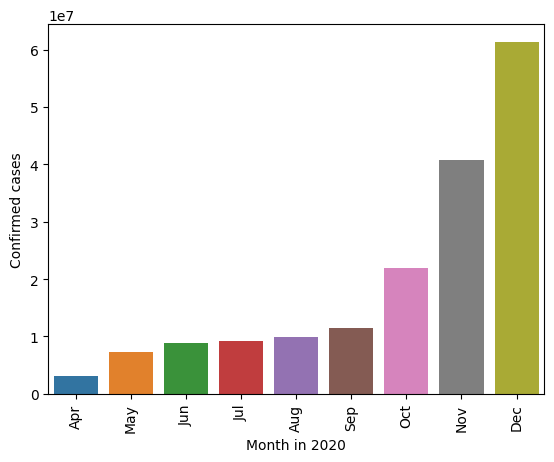

In [18]:
# get UK 2020 only dataframe and group by month
UK = (
    rdf.filter(
        (pl.col("Country/Region") == "UK")
        & (pl.col("ObservationDate").dt.year() == 2020)
        & (pl.col("ObservationDate").dt.month() > 3)  # get data for April-December 2020
    )
    .groupby(pl.col("ObservationDate").dt.month())
    .agg(pl.col("Confirmed").sum())
    .sort(pl.col("ObservationDate"))
)

UK.barplot(x="ObservationDate", y="Confirmed")
# set x and y labels
plt.ylabel("Confirmed cases")
plt.xlabel("Month in 2020")

# set x axis labels and totates X-Axis labels by 90 degrees
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    rotation=90,
)
plt.show()

### Pie chart

Next, we could display patient outcomes globally as a pie chart using the `pieplot` function.

Before we call `pieplot`, we first need to do a couple of small preparation steps. First, we need to select only `"Deaths"`, `"Recovered"` and `"Active_cases"`, as these are the segments we want to include in our pie chart. Second, we need to flip our `total` RemoteLazyFrame from wide to long form, using Polar's `melt` function as shown below.

In [19]:
selects = ["Deaths", "Active_cases", "Recovered"]
flipped = total.select(pl.col(x) for x in selects).melt()
flipped.collect().fetch()

variable,value
str,i64
"""Deaths""",2525401
"""Active_cases""",47016049
"""Recovered""",64243285


Now, that this is done, we can call pieplot on our `flipped` RemoteLazyFrame to get a pie chart of this data.

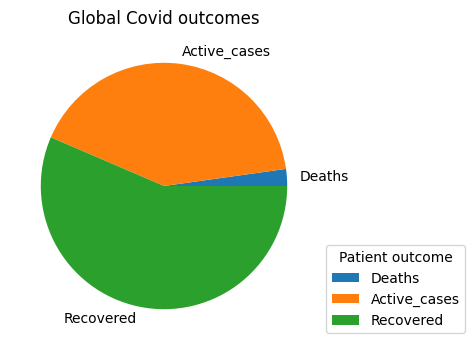

In [20]:
flipped.pieplot(
    parts="value",
    labels="variable",
    title="Global Covid outcomes",
    key_title="Patient outcome",
    key_loc="lower right",
)

To go further, let's imagine we want to see the outcomes, just for patients from France, Spain and Germany. We'll first filter down the `by_country` RemoteLazyFrame instance to only keep data relating to France, Germany and Spain and then we will `collect().fetch()` this new dataframe.

In [21]:
all_cols = ["Confirmed", "Country/Region", "Deaths", "Active_cases", "Recovered"]
agg_cols = ["Confirmed", "Deaths", "Active_cases", "Recovered"]

# create filtered down RemoteLazyFrame with data for France, Germany and Spain
FGS = rdf.filter(
    (pl.col("Country/Region") == "France")
    | (pl.col("Country/Region") == "Germany")
    | (pl.col("Country/Region") == "Spain")
)

compare = (
    FGS.filter(
        pl.col("ObservationDate") == pl.col("ObservationDate").max()
    )  # limit to data shared on latest observation date
    .select([pl.col(x) for x in all_cols])  # limit data to columns in all_cols list
    .groupby(pl.col("Country/Region"))  # group data by country
    .agg(
        [pl.col(x).sum() for x in agg_cols]
    )  # get the sum of values shared by each country on this date for each category in agg_cols
)

compare.collect().fetch()

Country/Region,Confirmed,Deaths,Active_cases,Recovered
str,i64,i64,i64,i64
"""Germany""",2444177,70092,121115,2252970
"""France""",3747263,85741,3399873,261649
"""Spain""",3188553,69142,2969035,150376


For the next visualization, we'll create a figure comparing the deaths, recovered and active cases in these three countries. This example illustrates how you can work with both our `pieplot` function and matplotlib `pyplot` to modify the output you will get from this function.

***#Hum, here I'm not sure what function you refer to with 'this function'. Probably need to make the sentence clearer =) Either by saying: "This example illustrates how you can work with matplotlib `pyplot` to modify the output you will get from the `pieplot`function." or something else =)***

In this example, instead of letting the `pieplot` function take care of creating our axis, we create our own `fig` and `ax` variables using matplotlib pyplot's `subplots` function in order to create a grid with three columns, one for each of the three pieplot's we will display. 

We then use a `for` loop to iterate over each column in our grid, we create the dataframe needed for each country's pie chart and we send our axis indexed to the correct column to get the following output:

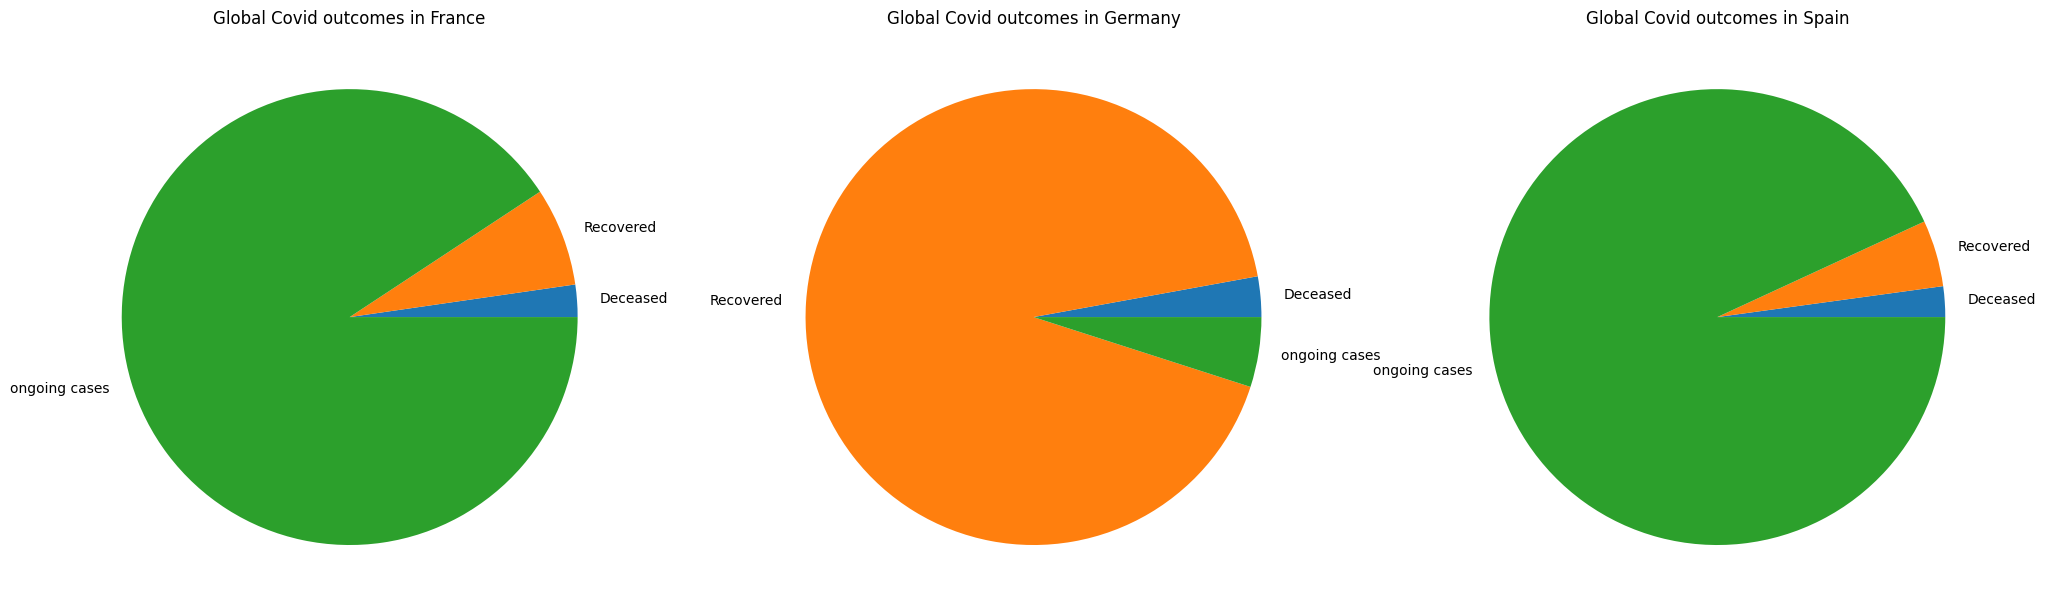

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(25, 20))
countries = ["France", "Germany", "Spain"]

count = 0
for i in range(3):
    pie = (
        compare.filter(pl.col("Country/Region") == countries[i])
        .select(pl.col(x) for x in ["Deaths", "Recovered", "Active_cases"])
        .melt()
    )
    pie.pieplot(
        parts="value",
        labels=["Deceased", "Recovered", "ongoing cases"],
        title="Global Covid outcomes in " + countries[i],
        key=False,
        ax=ax[i],
    )
plt.show()

After this, we decide to take a look at the maximum reported number of Covid cases by Province/State in Belgium. To do this, we'll create a fresh `RemoteLazyFrame` instance based on the original dataset. We'll filter the data down to the data released by Belgium and then group data by Province/State before collecting the max value of confirmed cases.

In [23]:
all_cols = ["Confirmed", "Province/State"]

belgium = (
    rdf.filter(
        (pl.col("Country/Region") == "Belgium")
    )  # limit data to data shared by Belgium on the latest observation date
    .select([pl.col(x) for x in all_cols])  # limit data to columns in all_cols list
    .groupby(pl.col("Province/State"))  # group data by province/state
    .agg(pl.col("Confirmed").max())  # get the sum of confirmed cases
)
belgium.collect().fetch()

Province/State,Confirmed
str,i64
"""Antwerp""",96758
"""Hainaut""",116242
"""East Flanders""",83146
"""Walloon Braban...",29898
"""Brussels""",95051
"""West Flanders""",68903
"""Limburg""",38363
"""Unknown""",515391
"""Flemish Braban...",59357


With this dataframe, we can make a donut chart displaying the percentage of cases for each region. To do this, we will create a pie chart using the `pieplot` function, and then add a white circle over the pie chart using matplotlib's `add_artist` to create the donut effect.

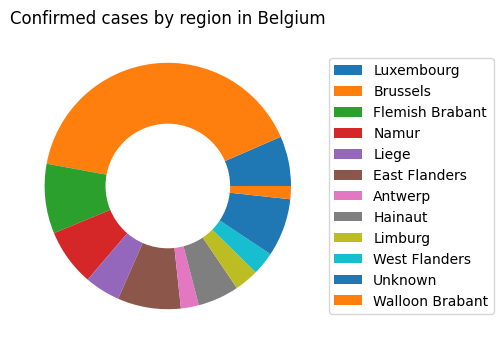

In [24]:
belgium.pieplot(
    parts="Confirmed",
    labels="Province/State",
    pie_labels=False,
    title="Confirmed cases by region in Belgium",
)
my_circle = plt.Circle((0, 0), 0.5, color="white")  # create a white circle

# get current pie chart figure using gcf() function and add white circle to it
fig = plt.gcf()
fig.gca().add_artist(my_circle)

# display donut
plt.show()

We're done with exploring this Covid-19 dataset with BastionLab. All that's left to do is close our connection!

In [25]:
connection.close()